<a href="https://colab.research.google.com/github/Bibhash123/competition_quickstart_dataloader/blob/main/Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This is a sample jupyter notebook to generate the prediction for competition submission

### Download and import custom module from RCI repo to get latest dataset from IPFS

In [ ]:
# # download custom module from RCI github repo which enable us to download dataset directly from IPFS
# !wget -O dataloader.py https://raw.githubusercontent.com/rocketcapital-ai/competition_quickstart_dataloader/main/dataloader.py

# # import modules
# import sys, zipfile
# from google.colab import files

# # append the directory of downloaded custom module to system path so we can import it
# sys.path.append('/content/')

# # install base58 module to decrpt the dataset
# !pip install base58

# # import the downloaded module
# from dataloader import download_dataset

# # download latest dataset from IPFS
# filename = download_dataset()

# # unzip the file
# with zipfile.ZipFile(filename, 'r') as zip_ref:
#     zip_ref.extractall()


In [1]:
!wget https://rocketcompetition.mypinata.cloud/ipfs/QmfH9YeyUL9bKBQ4MaYE3VQd7Pykocu4av12AhUBucDwm5
!unzip -q QmfH9YeyUL9bKBQ4MaYE3VQd7Pykocu4av12AhUBucDwm5 -d "/content/"
!rm -r QmfH9YeyUL9bKBQ4MaYE3VQd7Pykocu4av12AhUBucDwm5

--2022-06-20 07:04:27--  https://rocketcompetition.mypinata.cloud/ipfs/QmfH9YeyUL9bKBQ4MaYE3VQd7Pykocu4av12AhUBucDwm5
Resolving rocketcompetition.mypinata.cloud (rocketcompetition.mypinata.cloud)... 104.18.30.237, 104.18.31.237, 2606:4700::6812:1eed, ...
Connecting to rocketcompetition.mypinata.cloud (rocketcompetition.mypinata.cloud)|104.18.30.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 354504089 (338M) [application/zip]
Saving to: ‘QmfH9YeyUL9bKBQ4MaYE3VQd7Pykocu4av12AhUBucDwm5’

QmfH9YeyUL9bKBQ4MaY 100%[===================>] 338.08M   154MB/s    in 2.2s    

2022-06-20 07:04:30 (154 MB/s) - ‘QmfH9YeyUL9bKBQ4MaYE3VQd7Pykocu4av12AhUBucDwm5’ saved [354504089/354504089]



### Loading train_dataset and validation_dataset

In [3]:
from tqdm.notebook import tqdm
import os

In [4]:
import pandas as pd
import numpy as np
import scipy as sp
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

train_dataset  = pd.read_csv('/content/dataset/train_dataset.csv', index_col = 'date')
validation_dataset  = pd.read_csv('/content/dataset/validation_dataset.csv', index_col = 'date')
print("Shape of train set:",train_dataset.shape)
print("Shape of test set:",validation_dataset.shape)

Shape of train set: (80538, 2013)
Shape of test set: (669, 2013)


In [5]:
train_dataset = train_dataset.reset_index(drop=False).sort_values(by=["symbol","date"])
validation_dataset = validation_dataset.reset_index(drop=False).sort_values(by=["symbol","date"])

In [6]:
# first column (symbol) is the ticker
# 'target_DC1' is the log of return for delta between current close to previous close
# 'target' is the y which is ranked by Era using 'target_DC1'
# the rest of the columns are features to be used for ML
train_dataset.head()

,date,symbol,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_2003,feature_2004,feature_2005,feature_2006,feature_2007,feature_2008,feature_2009,feature_DC1,target,target_DC1
5122,2018-12-23,0xBTC,0.974026,0.987013,0.978355,0.991342,0.982684,0.982684,0.982684,0.978355,...,0.887446,0.857143,0.857143,0.857143,0.835498,0.839827,0.839827,0.891775,0.095238,-0.211551
5437,2018-12-30,0xBTC,0.016878,0.033755,0.949367,0.936709,0.978903,0.907173,0.962025,0.953586,...,0.936709,0.953586,0.962025,0.932489,0.940928,0.945148,0.915612,0.101266,0.046414,-0.192849
5737,2019-01-06,0xBTC,0.158996,0.016736,0.033473,0.928870,0.868201,0.941423,0.740586,0.933054,...,0.891213,0.874477,0.857741,0.912134,0.849372,0.807531,0.878661,0.050209,0.284519,-0.263822
5912,2019-01-13,0xBTC,0.737500,0.279167,0.020833,0.054167,0.945833,0.908333,0.962500,0.870833,...,0.645833,0.600000,0.541667,0.691667,0.591667,0.504167,0.670833,0.287500,0.391667,0.023985
6161,2019-01-20,0xBTC,0.983607,0.987705,0.983607,0.430328,0.971311,0.991803,0.987705,0.991803,...,0.504098,0.454918,0.422131,0.553279,0.368852,0.331967,0.450820,0.397541,0.032787,-0.251842


In [7]:
def rank_data(series):
    return (series.rank() - 1) / (len(series) - 1)

## Create Records

In [8]:
symbols = train_dataset.symbol.unique()
def prepareData(dataframe, savedir, window = 10):
  if not os.path.isdir(savedir):
    os.mkdir(savedir)

  records = []
  for sym in tqdm(symbols, "Preparing Train Data"):
    values = dataframe[dataframe['symbol']==sym].drop(["target",	"target_DC1", "date", "symbol"], axis = 1).values
    dates = dataframe[dataframe['symbol']==sym]['date'].values
    targets = dataframe[dataframe['symbol']==sym]['target'].values
    targets_dc1 = dataframe[dataframe['symbol']==sym]['target_DC1'].values
    if values.shape[0]<window:
      values = np.concatenate([np.zeros((window-values.shape[0], values.shape[1])), values], axis=0)
      targets = np.concatenate([np.zeros((window-targets.shape[0],)), targets], axis=0)
      targets_dc1 = np.concatenate([np.zeros((window-targets_dc1.shape[0],)), targets_dc1], axis=0)
      dates = np.concatenate([np.zeros((window-dates.shape[0],)), dates], axis=0)

    n = values.shape[0]
    for i in range(window,n+1,1):
      temp = values[i-window:i]
      t = targets[i-1]
      tdc1 = targets_dc1[i-1]
      d = dates[i-1]
      filename = os.path.join(savedir, f"{sym}_file_{d}.npz")
      np.savez(filename, temp, t)
      records.append([sym, d, filename, t, tdc1])

  files = pd.DataFrame(np.stack(records, axis = 0), columns = ["symbol", "date", "filename", "target", "target_DC1"])
  files = files.sort_values(by = ['date','symbol'])
  return files

def preparedValData(train_files, dataframe, savedir, window = 10):
  if not os.path.isdir(savedir):
    os.mkdir(savedir)

  records = []
  test_symbols = dataframe.symbol.unique()
  assert len(test_symbols)<= dataframe.shape[0], f"Length of dataframe greater than {len(test_symbols)}"

  for sym in tqdm(test_symbols, "Preparing test data"):
    if sym not in symbols:
      records.append([sym, np.nan, np.nan])
      continue

    rec = np.load(train_files[train_files["symbol"] == sym].iloc[-1,-3])['arr_0']
    assert rec.shape[-1]==2010, f"Incorrect shape of record: {rec.shape}"
    new_rec = np.expand_dims(dataframe[dataframe['symbol']==sym].iloc[0,2:-2].values,axis=0)
    new_rec = np.concatenate([rec[1:,:], new_rec],axis=0)

    assert new_rec.shape==(10,2010), f"Incorrect shape of new record {new_rec.shape}"
    d = dataframe[dataframe['symbol']==sym]['date'].values[0]
    filename = os.path.join(savedir, f"{sym}_file_{d}.npz")
    np.savez(filename, new_rec, axis = 0)
    records.append([sym, d, filename])

  files = pd.DataFrame(np.stack(records, axis = 0), columns = ["symbol", "date", "filename"])
  files = files.sort_values(by = ['date','symbol'])
  return files

In [9]:
train_files = prepareData(train_dataset, "/content/data")

Preparing Train Data:   0%|          | 0/962 [00:00<?, ?it/s]

In [10]:
test_files = preparedValData(train_files, validation_dataset, "/content/data")

Preparing test data:   0%|          | 0/669 [00:00<?, ?it/s]

## Data Loading

In [11]:
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K

BATCH_SIZE = 16

In [12]:
def build_generator(files, labelled = True):
  def load_data():
    for _,record in files.iterrows():
      temp = np.load(record['filename'])
      if labelled:
        yield temp['arr_0'], record['target_DC1']
      else:
        yield temp['arr_0']
  return load_data

def getDataset(files, batch = True, repeat = True, labelled = True):
  datagen = build_generator(files, labelled)
  data = tf.data.Dataset.from_generator(datagen, output_signature = (tf.TensorSpec(shape=(10,2010), dtype=tf.float32),
                                                              tf.TensorSpec(shape=(), dtype=tf.float32))
                                )
  data = data.batch(BATCH_SIZE) if batch else data
  data = data.repeat() if repeat else data
  return data

### Create X and y from train_dataset

### Each era representing a set of cryptocurrency assets for the time period, the number of assets within each Era is different

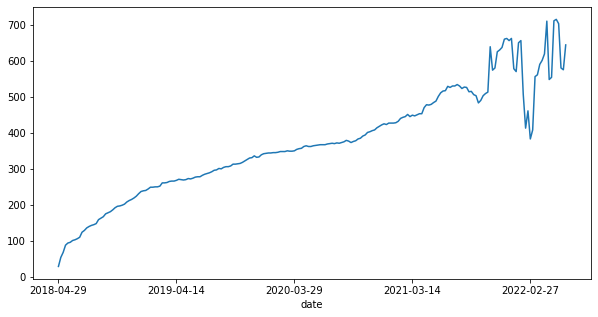

In [13]:
train_dataset.groupby(train_dataset.date).count().iloc[:,1].plot(figsize = (10,5));

### Split dataset into train and test by era

In [14]:
train = 0.9
test = 0.1
era = len(train_files.date.unique())
train_era = int(era * train)
test_era = era - train_era
print('total Era: {}'.format(era))
print('train Era: {}'.format(train_era))
print('validation Era: {}'.format(test_era))

total Era: 207
train Era: 186
validation Era: 21


In [15]:
#split train and test set according to the train_era and test_era
X_train = train_files.loc[train_files.date < train_files.date.unique()[train_era]]
X_test = train_files.loc[train_files.date >= train_files.date.unique()[train_era]]
print('Train dataset shape: {}'.format(X_train.shape))
print('Validation dataset shape: {}'.format(X_test.shape))

Train dataset shape: (61201, 5)
Validation dataset shape: (11035, 5)


In [16]:
train_data = getDataset(X_train, batch = True, repeat = True, labelled = True)
val_data = getDataset(X_test, batch = True, repeat = False, labelled = True)

# LSTM model building

In [17]:
class AttentionHead(L.Layer):
    def __init__(self, in_features, hidden_dim):
        super(AttentionHead,self).__init__()
        self.in_features = in_features
        self.middle_features = hidden_dim
        self.W = L.Dense(hidden_dim)
        self.V = L.Dense(1)
        self.out_features = hidden_dim
    
    def call(self, features):
        att = tf.keras.activations.tanh(self.W(features))
        score = self.V(att)
        attention_weights = tf.keras.activations.softmax(score, axis=1)
        context_vector = attention_weights * features
        context_vector = K.sum(context_vector, axis=1)

        return context_vector

In [18]:
def buildModel():
  inp = L.Input(shape = (10, 2010))
  h = L.LSTM(512, return_sequences = True)(inp)
  h = AttentionHead(2010, 512)(h)
  h = L.Dense(128, activation = "relu")(h)
  h = L.Dense(16, activation = "relu")(h)
  h = L.Dense(1, activation = "linear")(h)
  model = tf.keras.Model(inputs = inp, outputs=  h)
  model.compile(loss = "mse", optimizer = "adam")
  return model

model = buildModel()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 2010)]        0         
                                                                 
 lstm (LSTM)                 (None, 10, 512)           5167104   
                                                                 
 attention_head (AttentionHe  (None, 512)              263169    
 ad)                                                             
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 16)                2064      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                             

In [19]:
ckpt = tf.keras.callbacks.ModelCheckpoint('model.hdf5', monitor = 'val_loss', mode = 'min', save_best_only = True, 
                                          save_weights_only = True)
es = tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss', mode = 'min')

model.fit(train_data,
          epochs = 10,
          steps_per_epoch = X_train.shape[0]//BATCH_SIZE,
          validation_data = val_data,
          callbacks = [ckpt, es]
          )

Epoch 1/10
3825/3825 [==============================] - 190s 48ms/step - loss: 0.0760 - val_loss: 0.0404
Epoch 2/10
3825/3825 [==============================] - 193s 50ms/step - loss: 0.0748 - val_loss: 0.1096
Epoch 3/10
3825/3825 [==============================] - 204s 53ms/step - loss: 0.0751 - val_loss: 0.0403
Epoch 4/10
3825/3825 [==============================] - 195s 51ms/step - loss: 0.0751 - val_loss: 0.0403
Epoch 5/10
3825/3825 [==============================] - 179s 47ms/step - loss: 0.0751 - val_loss: 0.0402
Epoch 6/10
3825/3825 [==============================] - 177s 46ms/step - loss: 0.0750 - val_loss: 0.0402
Epoch 7/10
3825/3825 [==============================] - 178s 47ms/step - loss: 0.0751 - val_loss: 0.0402
Epoch 8/10
3825/3825 [==============================] - 179s 47ms/step - loss: 0.0751 - val_loss: 0.0401
Epoch 9/10
3825/3825 [==============================] - 194s 51ms/step - loss: 0.0751 - val_loss: 0.0401
Epoch 10/10
3825/3825 [==============================] 

### Use simple XGBoost to train a model

In [28]:
def loadSet(files, source, labelled = True):
  x,ydc,y = [],[],[]
  for _,row in files.iterrows():
    if pd.isnull(row['filename']):
      row = source[(source['symbol']==row['symbol'])&(source['date']==row['date'])]
      print(row.values.shape)
      x.append(row.values[2:-2])
    else:
      x.append(np.load(row['filename'], allow_pickle = True)['arr_0'][-1])
    if labelled:
      ydc.append(row['target_DC1'])
      y.append(row['target'])
      
  if labelled:    
    return np.stack(x, axis = 0), np.stack(ydc, axis = 0), np.stack(y, axis = 0)  
  else:
    return np.stack(x, axis = 0)


In [35]:
test_data = loadSet(test_files, validation_dataset, labelled = False)

In [ ]:
X_train_plain, Y_train_plain, target_train_plain = loadSet(X_train, train_dataset)
X_test_plain, Y_test_plain, target_test_plain = loadSet(X_test, train_dataset)

In [ ]:
from xgboost import XGBRegressor

params = {'objective' : "reg:squarederror", 'n_estimators' : 1000, 'tree_method' : "gpu_hist", 'max_depth':9, "reg_alpha":0.01}

reg = XGBRegressor(**params)
reg.fit(X_train_plain, Y_train_plain, eval_metric = "rmse",
        eval_set=[(X_train,Y_train_plain),(X_test_plain, Y_test_plain)], 
        early_stopping_rounds = 10, verbose = 100)

[0]	validation_0-rmse:0.286194	validation_1-rmse:0.288702
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
Stopping. Best iteration:
[18]	validation_0-rmse:0.245851	validation_1-rmse:0.286893



XGBRegressor(max_depth=9, n_estimators=1000, objective='reg:squarederror',
             reg_alpha=0.01, tree_method='gpu_hist')

In [ ]:
def predictFunction(lstm,xgb,files, x_test):
  test_ = getDataset(files, batch = True, repeat = False, labelled = False)
  

In [ ]:
# function to calculate Spearman correlation by era (mean, std, max, min)
# we want to maximize but maintain stable correlation across era to maximize both challenge and competition reward
def spearman_by_era(prediction, target):
  df = pd.DataFrame(index=target.index,
                    data = {'prediction': prediction,
                            'target': target}
                    )
  
  spearman_era_list = []
  for era in df.index.unique():
    era_df = df[df.index == era]
    spearman_corr = sp.stats.spearmanr(era_df.prediction, era_df.target)[0]
    spearman_era_list.append(spearman_corr)

  mean = np.mean(spearman_era_list)
  std = np.std(spearman_era_list)
  max = np.max(spearman_era_list)
  min = np.min(spearman_era_list)
  return mean, std, max, min
  
y_pred_train = reg.predict(X_train)
train_spearman = spearman_by_era(y_pred_train, y_train)
print('Train dataset Spearman correlation: mean = {} ; std = {} ; max = {} ; min = {}'.format(round(train_spearman[0], 4), 
                                                                                            round(train_spearman[1], 4),
                                                                                            round(train_spearman[2], 4),
                                                                                            round(train_spearman[3], 4),
                                                                                            ))

y_pred_test = reg.predict(X_test)
test_spearman = spearman_by_era(y_pred_test, y_test)
print('Test dataset Spearman correlation: mean = {} ; std = {} ; max = {} ; min = {}'.format(round(test_spearman[0], 4),
                                                                                            round(test_spearman[1], 4),
                                                                                            round(test_spearman[2], 4),
                                                                                            round(test_spearman[3], 4),
                                                                                            ))


Train dataset Spearman correlation: mean = 0.7047 ; std = 0.0369 ; max = 0.8377 ; min = 0.5771
Test dataset Spearman correlation: mean = 0.1037 ; std = 0.0628 ; max = 0.2461 ; min = -0.0039


In [ ]:
# Use the trained Linear Regression model to make prediction on latest data

X_validation = validation_dataset.iloc[:, 1:-2]
y_validation_linear_reg = reg.predict(X_validation)

y_validation_linear_reg[:5]

array([0.47534436, 0.5070021 , 0.35265437, 0.4615777 , 0.5145721 ],
      dtype=float32)

### Let's use the prediction from linear regression to join with validation dataset symbol for submission

In [ ]:
prediction = pd.DataFrame()
prediction['symbol'] = list(validation_dataset.symbol)
prediction['prediction'] = y_validation_linear_reg

# sort the prediction to check which symbol is weaker and stronger, ie. FOX is weakest; BTC is strongest
prediction.sort_values('prediction')

,symbol,prediction
127,IXT,0.231780
677,DYP,0.267667
549,FNB,0.296755
291,PRQ,0.304200
72,DMT,0.304408
...,...,...
443,S4F,0.630962
78,MTH,0.632966
57,RDN,0.650649
588,PPAY,0.658112


### Check is prediction dataframe in accordance for submission format (using the prediction from linear regression)

In [ ]:
#check if y_latest is in accordance to shape for submission
if set(prediction.symbol) == set(validation_dataset.symbol):
    print('symbol matched!')
else:
    print('symbol unmatched, the symbol in prediction df must match the symbol in validation_dataset...')
    
if prediction.shape[1] == 2:
    print('column counts ok!')
else:
    print('It should have 2 columns, first column with symbol, second with prediction...')


symbol matched!
column counts ok!


### Output prediction as a .csv file for submission!

In [ ]:
#Output submission as .csv file
#The prediction.csv is stored in content/prediction folder
import os
if not os.path.exists('/content/prediction'):
    os.makedirs('/content/prediction')
prediction.to_csv('/content/prediction/prediction.csv', index = False, header = None)

# **Submission Section**

## **Setup**

In [ ]:
!git clone https://github.com/rocketcapital-ai/competition_submission.git
%cd /content/competition_submission

Cloning into 'competition_submission'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 23 (delta 3), reused 19 (delta 3), pack-reused 0
Unpacking objects: 100% (23/23), done.
/content/competition_submission


In [ ]:
!pip install base58
!pip install PyYAML
!pip install requests
!pip install web3
!pip install pandas 
from IPython.display import clear_output
clear_output(wait = False)

In [ ]:
from lib.submitter import *

jwt = 'eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJ1c2VySW5mb3JtYXRpb24iOnsiaWQiOiIxMDIwZDY0OC1kNzQ5LTQ5YjItOTZmZS1hNWQ0NDY5ODRjNTQiLCJlbWFpbCI6ImJpYmhhc2hwLmRhc0BnbWFpbC5jb20iLCJlbWFpbF92ZXJpZmllZCI6dHJ1ZSwicGluX3BvbGljeSI6eyJyZWdpb25zIjpbeyJpZCI6IkZSQTEiLCJkZXNpcmVkUmVwbGljYXRpb25Db3VudCI6MX0seyJpZCI6Ik5ZQzEiLCJkZXNpcmVkUmVwbGljYXRpb25Db3VudCI6MX1dLCJ2ZXJzaW9uIjoxfSwibWZhX2VuYWJsZWQiOmZhbHNlLCJzdGF0dXMiOiJBQ1RJVkUifSwiYXV0aGVudGljYXRpb25UeXBlIjoic2NvcGVkS2V5Iiwic2NvcGVkS2V5S2V5IjoiYmM4NWI0ZDQ1N2FhYWZlNzBmNGIiLCJzY29wZWRLZXlTZWNyZXQiOiJlMmEyOGFlZmFlNTcyMWZkNzM1Mjg4NzE5OTIzYTBkZTQ4MWY5NzUxZWQyZmVhMTE0MGJmYzRlNzNjNzRhYzI2IiwiaWF0IjoxNjU1MTM2Nzc4fQ.xl2FxgrL04kQIa7cIn89a_iE0I9xphiNf6K5K2mor5o'      # User-specified field.
address = '0xcF16365d53ed53055f39010830e3CcD5A7a8245E'  # User-specified field.
pk = '32316dfe607ed4a240ac29a6dcad9db6f484f0fbdf7894c15511237e1e13db70'       # User-specified field.
submitter = Submitter(jwt, address, pk)

## View wallet address information.

In [ ]:
print('MATIC balance for {}: {}'.format(submitter.address, submitter.get_matic_balance()))
print('MUSA balance for {}: {}'.format(submitter.address, submitter.get_musa_balance()))
print('Current stake for {}: {}'.format(submitter.address, submitter.get_stake()))

MATIC balance for 0xcF16365d53ed53055f39010830e3CcD5A7a8245E: 1.050000000000000000
MUSA balance for 0xcF16365d53ed53055f39010830e3CcD5A7a8245E: 100.000000000000000000
Current stake for 0xcF16365d53ed53055f39010830e3CcD5A7a8245E: 0


## **Retrieve Dataset and run models.**
### Please follow the instructions and example found [here](https://github.com/rocketcapital-ai/competition_quickstart_dataloader).

### When completed, please place final prediction csv file in the `file_to_submit` folder.

In [ ]:
!cp "/content/prediction/prediction.csv" "/content/competition_submission/file_to_submit/"

## **Set stake.** (optional)
### Skip if no changes need to be made.

In [ ]:
# set_stake_amount = 100.00  # User-specified field.
# transaction_success = submitter.set_stake(set_stake_amount)
# assert transaction_success, 'Setting stake failed.'

Setting gas price to 108 gwei.
Sending transaction 0xde821ad79f52afc0299ff26596794dc2c0d875b34e883aeb54a885fb5cdae0ed
Transaction sent. Tx ID: 0xde821ad79f52afc0299ff26596794dc2c0d875b34e883aeb54a885fb5cdae0ed


## **Submit predictions.**
Note that the same `submit_prediction` method should be used for re-submitting predictions.

In [ ]:
submission_file_name = 'prediction.csv'  # User-specified field.
transaction_success = submitter.submit_prediction(submission_file_name)
assert transaction_success, 'Submission failed.'

Encrypting file.
Zipping encrypted file.
Uploading and recording on blockchain.
Setting gas price to 131 gwei.
Sending transaction 0x965b44ace1851954c237f47b384da0e52bc1772dc56261e37da0eea9fd8e1fcd
Transaction sent. Tx ID: 0x965b44ace1851954c237f47b384da0e52bc1772dc56261e37da0eea9fd8e1fcd


### **Retrieve and double-check predictions.** (optional)
This section retrieves your submitted files, decrypts them, and compares them to the original file in `file_to_submit`.

If the verification fails, please wait a few minutes and perform the verification again. If the problem persists, please re-submit your predictions.

In [ ]:
verification_success = submitter.download_and_check(submission_file_name)
assert verification_success, 'Submission verification failed.'
print('Files are identical. Verification check passed.')

Retrieving file.
File retrieved.
File unzipped.
File decrypted. Comparing files.
Removing temp files.
Temp files removed.
Files are identical. Verification check passed.
